<a href="https://colab.research.google.com/github/shivamsinghtomar78/ML-Projects-/blob/main/Healthcare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics
!pip install albumentations
!pip install opencv-python
!pip install matplotlib
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.2/949.2 kB 14.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [6]:
import os
import random
import shutil
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
from tqdm.notebook import tqdm
import torch
import albumentations as A
from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [7]:
# Check if GPU is available
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"Current GPU: {torch.cuda.get_device_name()}")
    print(f"Number of GPUs: {torch.cuda.device_count()}")

CUDA available: True
Current GPU: Tesla T4
Number of GPUs: 1


In [8]:
# Clone the BCCD Dataset repository
!git clone https://github.com/Shenggan/BCCD_Dataset.git

fatal: destination path 'BCCD_Dataset' already exists and is not an empty directory.


In [9]:
# Set random seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [10]:
# Create directories for YOLO format data
def create_directory_structure():
    os.makedirs("BCCD_YOLO/images/train", exist_ok=True)
    os.makedirs("BCCD_YOLO/images/val", exist_ok=True)
    os.makedirs("BCCD_YOLO/images/test", exist_ok=True)
    os.makedirs("BCCD_YOLO/labels/train", exist_ok=True)
    os.makedirs("BCCD_YOLO/labels/val", exist_ok=True)
    os.makedirs("BCCD_YOLO/labels/test", exist_ok=True)
    os.makedirs("BCCD_YOLO/augmented/images/train", exist_ok=True)
    os.makedirs("BCCD_YOLO/augmented/labels/train", exist_ok=True)
    print("Directory structure created successfully.")

create_directory_structure()

Directory structure created successfully.


In [11]:
# Define class mapping for BCCD dataset
class_map = {
    'RBC': 0,   # Red Blood Cells
    'WBC': 1,   # White Blood Cells
    'Platelets': 2
}

In [12]:
# Function to convert VOC XML annotations to YOLO txt format
def convert_voc_to_yolo(xml_file, output_file, image_width, image_height):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    with open(output_file, 'w') as f:
        for obj in root.findall('./object'):
            class_name = obj.find('name').text
            if class_name in class_map:
                class_id = class_map[class_name]
                bndbox = obj.find('bndbox')
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)

                # Ensure coordinates are within image boundaries
                xmin = max(0, min(xmin, image_width))
                ymin = max(0, min(ymin, image_height))
                xmax = max(0, min(xmax, image_width))
                ymax = max(0, min(ymax, image_height))

                # Convert to YOLO format (center_x, center_y, width, height) - normalized
                center_x = ((xmin + xmax) / 2) / image_width
                center_y = ((ymin + ymax) / 2) / image_height
                width = (xmax - xmin) / image_width
                height = (ymax - ymin) / image_height

                # Write to file
                f.write(f"{class_id} {center_x} {center_y} {width} {height}\n")

In [16]:
# Process the BCCD dataset and convert to YOLO format
def process_bccd_dataset():
    images_dir = 'BCCD_Dataset/BCCD/JPEGImages'
    annot_dir = 'BCCD_Dataset/BCCD/Annotations'

    if not os.path.exists(images_dir) or not os.path.exists(annot_dir):
        print(f"Error: {images_dir} or {annot_dir} does not exist!")
        return []

    all_images = sorted([f for f in os.listdir(images_dir) if f.endswith('.jpg')])

    print(f"Total images found: {len(all_images)}")

    # Split data (80% train, 10% val, 10% test)
    random.shuffle(all_images)
    num_images = len(all_images)
    train_split = int(0.8 * num_images)
    val_split = int(0.9 * num_images)

    train_images = all_images[:train_split]
    val_images = all_images[train_split:val_split]
    test_images = all_images[val_split:]

    print(f"Dataset split - Train: {len(train_images)}, Val: {len(val_images)}, Test: {len(test_images)}")

    class_counts = {class_name: 0 for class_name in class_map.keys()}

    splits = [
        ('train', train_images),
        ('val', val_images),
        ('test', test_images)
    ]

    for split_name, split_images in splits:
        for img_file in tqdm(split_images, desc=f"Processing {split_name} set"):
            img_path = os.path.join(images_dir, img_file)
            xml_file = os.path.join(annot_dir, img_file.replace('.jpg', '.xml'))

            if not os.path.exists(xml_file):
                print(f"Warning: Annotation file {xml_file} not found!")
                continue

            img = Image.open(img_path)
            width, height = img.size

            dst_img_path = f"BCCD_YOLO/images/{split_name}/{img_file}"
            shutil.copy(img_path, dst_img_path)

            output_label_file = f"BCCD_YOLO/labels/{split_name}/{img_file.replace('.jpg', '.txt')}"
            convert_voc_to_yolo(xml_file, output_label_file, width, height)

            tree = ET.parse(xml_file)
            root = tree.getroot()
            for obj in root.findall('./object'):
                class_name = obj.find('name').text
                if class_name in class_map:
                    class_counts[class_name] += 1

    print("\nClass distribution in dataset:")
    for class_name, count in class_counts.items():
        print(f"  {class_name}: {count} instances")

    with open("BCCD_YOLO/dataset.yaml", "w") as f:
        f.write("path: ./BCCD_YOLO\n")
        f.write("train: images/train\n")
        f.write("val: images/val\n")
        f.write("test: images/test\n\n")
        f.write("nc: 3\n")
        f.write("names:\n")
        for class_name, class_id in class_map.items():
            f.write(f"  {class_id}: {class_name}\n")

    print("YOLO dataset.yaml file created successfully.")
    return train_images

train_images = process_bccd_dataset()

Total images found: 364
Dataset split - Train: 291, Val: 36, Test: 37


Processing train set:   0%|          | 0/291 [00:00<?, ?it/s]

Processing val set:   0%|          | 0/36 [00:00<?, ?it/s]

Processing test set:   0%|          | 0/37 [00:00<?, ?it/s]


Class distribution in dataset:
  RBC: 4155 instances
  WBC: 372 instances
  Platelets: 361 instances
YOLO dataset.yaml file created successfully.


<ipython-input-18-f89475422ec0>:15: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),


Augmenting images:   0%|          | 0/291 [00:00<?, ?it/s]

Error during augmentation: x_max is less than or equal to x_min for bbox [     0.7875     0.70208      0.7875     0.70208           0].
Error during augmentation: x_max is less than or equal to x_min for bbox [     0.7875     0.70208      0.7875     0.70208           0].
Error during augmentation: x_max is less than or equal to x_min for bbox [     0.7875     0.70208      0.7875     0.70208           0].
Error during augmentation: x_max is less than or equal to x_min for bbox [    0.28281     0.68542     0.28281     0.68542           0].
Error during augmentation: x_max is less than or equal to x_min for bbox [    0.28281     0.68542     0.28281     0.68542           0].
Error during augmentation: x_max is less than or equal to x_min for bbox [    0.28281     0.68542     0.28281     0.68542           0].
Created 867 augmented images
Final training set size: 1386 images
Displaying sample images from training set (including augmented images):


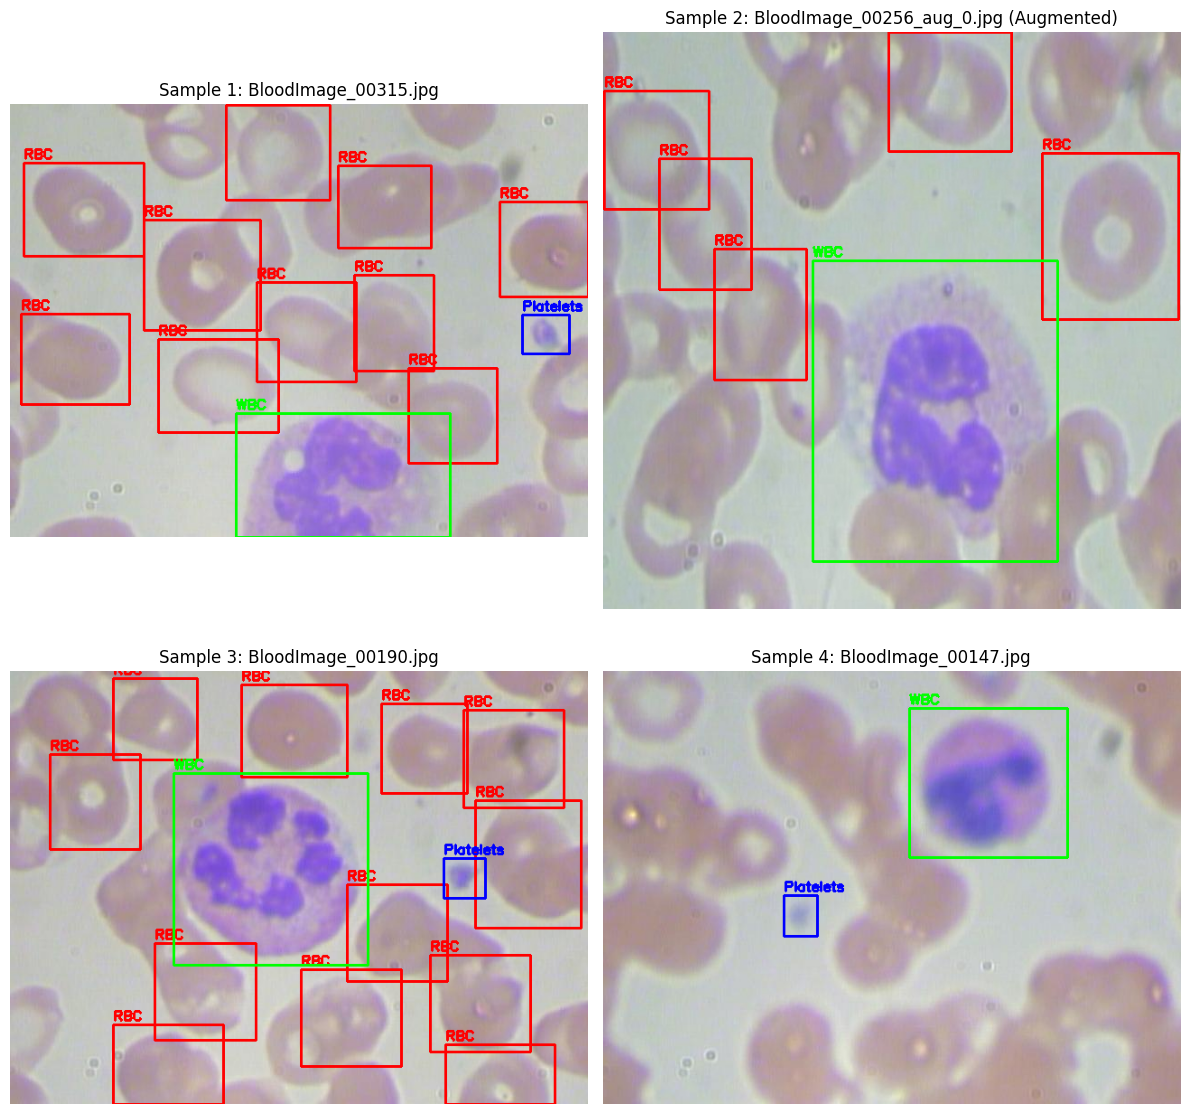

In [18]:
def augment_dataset(train_images):
    images_dir = 'BCCD_Dataset/BCCD/JPEGImages'

    augmentations = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomRotate90(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.RandomSizedBBoxSafeCrop(height=640, width=640, p=0.5),
        A.GaussianBlur(blur_limit=(3, 7), p=0.3),
        A.CLAHE(clip_limit=4.0, p=0.3),
        A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.3),
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.3),
        A.GaussNoise(var_limit=(10.0, 50.0), p=0.2),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels']))

    augmented_count = 0

    for img_file in tqdm(train_images, desc="Augmenting images"):
        img_path = os.path.join(images_dir, img_file)
        image = cv2.imread(img_path)

        if image is None:
            print(f"Warning: Failed to load image {img_path}")
            continue

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        label_path = f"BCCD_YOLO/labels/train/{img_file.replace('.jpg', '.txt')}"

        bboxes = []
        class_labels = []

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    data = line.strip().split()
                    class_id = int(data[0])
                    x_center, y_center, width, height = map(float, data[1:5])
                    bboxes.append([x_center, y_center, width, height])
                    class_labels.append(class_id)

        for i in range(3):
            if bboxes:
                try:
                    augmented = augmentations(image=image, bboxes=bboxes, class_labels=class_labels)

                    aug_image = augmented['image']
                    aug_bboxes = augmented['bboxes']
                    aug_labels = augmented['class_labels']

                    # Skip if no valid bounding boxes are left
                    if not aug_bboxes:
                        continue

                    # Check for invalid bounding boxes
                    valid_bboxes = []
                    valid_labels = []
                    for bbox, label in zip(aug_bboxes, aug_labels):
                        x_center, y_center, width, height = bbox
                        if width > 0 and height > 0:
                            valid_bboxes.append(bbox)
                            valid_labels.append(label)

                    if not valid_bboxes:
                        continue

                    aug_img_path = f"BCCD_YOLO/augmented/images/train/{img_file.replace('.jpg', f'_aug_{i}.jpg')}"
                    aug_label_path = f"BCCD_YOLO/augmented/labels/train/{img_file.replace('.jpg', f'_aug_{i}.txt')}"

                    aug_image_bgr = cv2.cvtColor(aug_image, cv2.COLOR_RGB2BGR)
                    cv2.imwrite(aug_img_path, aug_image_bgr)

                    with open(aug_label_path, 'w') as f:
                        for bbox, label in zip(valid_bboxes, valid_labels):
                            x_center, y_center, width, height = bbox
                            f.write(f"{int(label)} {x_center} {y_center} {width} {height}\n")

                    augmented_count += 1
                except Exception as e:
                    print(f"Error during augmentation: {e}")

    print(f"Created {augmented_count} augmented images")

    !cp BCCD_YOLO/augmented/images/train/* BCCD_YOLO/images/train/
    !cp BCCD_YOLO/augmented/labels/train/* BCCD_YOLO/labels/train/

    train_count = len(os.listdir('BCCD_YOLO/images/train'))
    print(f"Final training set size: {train_count} images")

augment_dataset(train_images)

def display_sample_images(num_samples=4, split='train'):
    fig, axes = plt.subplots(2, 2, figsize=(12, 12))
    axes = axes.flatten()

    sample_files = os.listdir(f'BCCD_YOLO/images/{split}')
    random.shuffle(sample_files)

    for i, img_file in enumerate(sample_files[:num_samples]):
        img_path = os.path.join(f'BCCD_YOLO/images/{split}', img_file)
        label_path = os.path.join(f'BCCD_YOLO/labels/{split}', img_file.replace('.jpg', '.txt'))

        img = cv2.imread(img_path)
        if img is None:
            print(f"Warning: Could not load image {img_path}")
            continue

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        height, width, _ = img.shape

        colors = {
            0: (255, 0, 0),    # Red for RBC
            1: (0, 255, 0),    # Green for WBC
            2: (0, 0, 255)     # Blue for Platelets
        }

        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                for line in f:
                    data = line.strip().split()
                    class_id = int(data[0])
                    x_center, y_center, bbox_width, bbox_height = map(float, data[1:5])

                    x1 = int((x_center - bbox_width/2) * width)
                    y1 = int((y_center - bbox_height/2) * height)
                    x2 = int((x_center + bbox_width/2) * width)
                    y2 = int((y_center + bbox_height/2) * height)

                    color = colors.get(class_id, (0, 255, 0))
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

                    class_name = next((name for name, id in class_map.items() if id == class_id), str(class_id))
                    cv2.putText(img, class_name, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        axes[i].imshow(img)
        title = f"Sample {i+1}: {img_file}"
        if "_aug_" in img_file:
            title += " (Augmented)"
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

print("Displaying sample images from training set (including augmented images):")
display_sample_images(num_samples=4, split='train')

In [34]:
# Create the directories if they don't exist
!mkdir -p /content/datasets/BCCD_YOLO/images
!mkdir -p /content/datasets/BCCD_YOLO/labels

# Create symbolic links to your actual data
!ln -s /content/BCCD_YOLO/images/train /content/datasets/BCCD_YOLO/images/train
!ln -s /content/BCCD_YOLO/images/val /content/datasets/BCCD_YOLO/images/val
!ln -s /content/BCCD_YOLO/labels/train /content/datasets/BCCD_YOLO/labels/train
!ln -s /content/BCCD_YOLO/labels/val /content/datasets/BCCD_YOLO/labels/val

# Copy your dataset.yaml to the expected location
!cp /content/BCCD_YOLO/dataset.yaml /content/datasets/BCCD_YOLO/

In [35]:
def train_yolov10():
    model = YOLO('yolov10m.pt')  # Medium-sized model

    train_params = {
        'data':'/content/datasets/BCCD_YOLO/dataset.yaml',
        'epochs': 30,
        'imgsz': 640,
        'batch': 16,
        'workers': 4,
        'patience': 5,
        'save': True,
        'device': 0 if torch.cuda.is_available() else 'cpu',
        'project': 'BCCD_YOLOv10',
        'name': 'finetuned',
        'pretrained': True,
        'optimizer': 'auto',
        'cos_lr': True,
        'val': True,
        'cache': True
    }

    print("Training configuration:")
    for key, value in train_params.items():
        print(f"  {key}: {value}")

    try:
        results = model.train(**train_params)
        print("Training completed successfully!")

        metrics = results.results_dict
        print("\nTraining results:")
        for key, value in metrics.items():
            if isinstance(value, (int, float)):
                print(f"  {key}: {value}")

        val_results = model.val()
        print("\nValidation results:")
        print(f"  mAP50: {val_results.box.map50:.4f}")
        print(f"  mAP50-95: {val_results.box.map:.4f}")

        return model

    except Exception as e:
        print(f"Error during training: {e}")
        return None

model = train_yolov10()

def plot_training_metrics():
    try:
        results_file = 'BCCD_YOLOv10/finetuned/results.csv'
        if not os.path.exists(results_file):
            print(f"Results file not found: {results_file}")
            return

        import pandas as pd

        results = pd.read_csv(results_file)

        fig, ax = plt.subplots(2, 2, figsize=(15, 10))

        ax[0, 0].plot(results['epoch'], results['train/box_loss'], label='train')
        if 'val/box_loss' in results.columns:
            ax[0, 0].plot(results['epoch'], results['val/box_loss'], label='val')
        ax[0, 0].set_title('Box Loss')
        ax[0, 0].set_xlabel('Epoch')
        ax[0, 0].set_ylabel('Loss')
        ax[0, 0].legend()

        if 'train/cls_loss' in results.columns:
            ax[0, 1].plot(results['epoch'], results['train/cls_loss'], label='train')
            if 'val/cls_loss' in results.columns:
                ax[0, 1].plot(results['epoch'], results['val/cls_loss'], label='val')
            ax[0, 1].set_title('Classification Loss')
            ax[0, 1].set_xlabel('Epoch')
            ax[0, 1].set_ylabel('Loss')
            ax[0, 1].legend()

        if 'metrics/precision' in results.columns:
            ax[1, 0].plot(results['epoch'], results['metrics/precision'], label='precision')
            ax[1, 0].set_title('Precision')
            ax[1, 0].set_xlabel('Epoch')
            ax[1, 0].set_ylabel('Precision')

        if 'metrics/mAP_0.5' in results.columns:
            ax[1, 1].plot(results['epoch'], results['metrics/mAP_0.5'], label='mAP@0.5')
            if 'metrics/mAP_0.5:0.95' in results.columns:
                ax[1, 1].plot(results['epoch'], results['metrics/mAP_0.5:0.95'], label='mAP@0.5:0.95')
            ax[1, 1].set_title('mAP')
            ax[1, 1].set_xlabel('Epoch')
            ax[1, 1].set_ylabel('mAP')
            ax[1, 1].legend()

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting metrics: {e}")

plot_training_metrics()

Training configuration:
  data: /content/datasets/BCCD_YOLO/dataset.yaml
  epochs: 30
  imgsz: 640
  batch: 16
  workers: 4
  patience: 5
  save: True
  device: 0
  project: BCCD_YOLOv10
  name: finetuned
  pretrained: True
  optimizer: auto
  cos_lr: True
  val: True
  cache: True
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10m.pt, data=/content/datasets/BCCD_YOLO/dataset.yaml, epochs=30, time=None, patience=5, batch=16, imgsz=640, save=True, save_period=-1, cache=True, device=0, workers=4, project=BCCD_YOLOv10, name=finetuned15, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=True, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, h

100%|██████████| 755k/755k [00:00<00:00, 23.9MB/s]


Overriding model.yaml nc=80 with nc=3

                   from  n    params  module                                       arguments                     
  0                  -1  1      1392  ultralytics.nn.modules.conv.Conv             [3, 48, 3, 2]                 
  1                  -1  1     41664  ultralytics.nn.modules.conv.Conv             [48, 96, 3, 2]                
  2                  -1  2    111360  ultralytics.nn.modules.block.C2f             [96, 96, 2, True]             
  3                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  4                  -1  4    813312  ultralytics.nn.modules.block.C2f             [192, 192, 4, True]           
  5                  -1  1     78720  ultralytics.nn.modules.block.SCDown          [192, 384, 3, 2]              
  6                  -1  4   3248640  ultralytics.nn.modules.block.C2f             [384, 384, 4, True]           
  7                  -1  1    228672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.5MB/s]


AMP: checks passed ✅


train: Scanning /content/BCCD_YOLO/labels/train... 1386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1386/1386 [00:00<00:00, 1961.03it/s]

train: New cache created: /content/BCCD_YOLO/labels/train.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (1.3GB RAM): 100%|██████████| 1386/1386 [00:04<00:00, 317.74it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/BCCD_YOLO/labels/val... 68 images, 0 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<00:00, 1326.98it/s]

val: New cache created: /content/BCCD_YOLO/labels/val.cache
WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 68/68 [00:00<00:00, 233.60it/s]


Plotting labels to BCCD_YOLOv10/finetuned15/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 129 weight(decay=0.0), 142 weight(decay=0.0005), 141 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to BCCD_YOLOv10/finetuned15
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      8.35G      2.691      3.224      3.226        173        640: 100%|██████████| 87/87 [00:57<00:00,  1.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.52it/s]


                   all         68        894      0.668      0.779        0.8      0.489

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30       9.3G      2.508      1.844      2.966        292        640: 100%|██████████| 87/87 [00:55<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.87it/s]

                   all         68        894      0.723      0.884      0.845      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      9.38G      2.502      1.764      2.918        343        640: 100%|██████████| 87/87 [00:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         68        894      0.731      0.774      0.791      0.392



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      9.45G      2.411      1.692      2.837        251        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         68        894      0.761       0.82      0.873      0.533



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      9.53G      2.357      1.683      2.805        178        640: 100%|██████████| 87/87 [00:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.26it/s]

                   all         68        894      0.727      0.795      0.897      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      9.61G      2.269      1.523       2.72        164        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         68        894      0.871       0.82      0.908      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      9.69G      2.203      1.463      2.675        274        640: 100%|██████████| 87/87 [00:55<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.05it/s]

                   all         68        894      0.783      0.892      0.889      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      9.77G      2.167      1.442      2.638        254        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.34it/s]

                   all         68        894      0.806      0.906       0.92      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      9.85G      2.093      1.355      2.596        238        640: 100%|██████████| 87/87 [00:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.06it/s]

                   all         68        894      0.823      0.866        0.9      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      9.93G      2.046      1.316      2.579        193        640: 100%|██████████| 87/87 [00:55<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.28it/s]

                   all         68        894      0.841      0.891      0.906      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30        10G      1.981      1.256      2.524        226        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         68        894      0.813      0.871       0.91      0.614



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      10.1G      1.928      1.223      2.473        292        640: 100%|██████████| 87/87 [00:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.12it/s]

                   all         68        894      0.832      0.911       0.92      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      10.2G      1.872      1.158      2.439        310        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         68        894      0.865      0.864      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      10.2G      1.834      1.135      2.431        260        640: 100%|██████████| 87/87 [00:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.35it/s]

                   all         68        894      0.832      0.895      0.918      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      10.3G      1.781      1.114      2.398        270        640: 100%|██████████| 87/87 [00:54<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.33it/s]

                   all         68        894      0.847      0.879      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      10.4G      1.756      1.096      2.387        236        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.37it/s]

                   all         68        894      0.875      0.887      0.921      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      10.5G      1.658      1.033      2.314        251        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


                   all         68        894      0.857      0.902      0.923      0.654

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      10.6G      1.583     0.9824      2.275        224        640: 100%|██████████| 87/87 [00:55<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         68        894      0.876      0.845      0.918      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      10.6G       1.55     0.9596      2.264        266        640: 100%|██████████| 87/87 [00:55<00:00,  1.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.88it/s]

                   all         68        894      0.849      0.929      0.922      0.649



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      10.7G      1.469     0.9109      2.211        188        640: 100%|██████████| 87/87 [00:54<00:00,  1.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         68        894      0.863      0.924      0.926      0.661


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      10.8G       2.31      1.515      2.827        128        640: 100%|██████████| 87/87 [00:54<00:00,  1.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         68        894      0.877      0.887       0.93      0.664



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      10.9G       2.26      1.446      2.761        112        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.97it/s]

                   all         68        894      0.885      0.898      0.939      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      10.9G      2.229      1.418      2.742        127        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.30it/s]

                   all         68        894      0.878      0.901      0.933      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30        11G      2.173      1.378      2.697        113        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.24it/s]

                   all         68        894      0.908      0.886      0.942      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      11.1G      2.139      1.339       2.65        115        640: 100%|██████████| 87/87 [00:53<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.03it/s]

                   all         68        894      0.898      0.897      0.945      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      11.2G      2.093      1.306      2.608        112        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         68        894      0.867      0.929      0.939      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      11.3G      2.072      1.296      2.605        136        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.36it/s]

                   all         68        894      0.905      0.909      0.941      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      11.3G      2.066      1.283      2.596        119        640: 100%|██████████| 87/87 [00:53<00:00,  1.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.25it/s]

                   all         68        894      0.896       0.91      0.943      0.708



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      11.4G      2.049      1.266      2.585        146        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         68        894      0.896      0.909      0.941      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      11.5G      2.025      1.259       2.57        125        640: 100%|██████████| 87/87 [00:53<00:00,  1.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.31it/s]

                   all         68        894      0.905      0.903      0.943      0.707



30 epochs completed in 0.486 hours.
Optimizer stripped from BCCD_YOLOv10/finetuned15/weights/last.pt, 33.5MB
Optimizer stripped from BCCD_YOLOv10/finetuned15/weights/best.pt, 33.5MB

Validating BCCD_YOLOv10/finetuned15/weights/best.pt...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 159 layers, 16,453,858 parameters, 0 gradients, 63.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.80it/s]


                   all         68        894      0.899      0.908      0.943      0.708
                   RBC         62        757      0.873      0.798       0.91        0.7
                   WBC         67         69      0.972      0.986       0.99       0.86
             Platelets         34         68      0.851      0.941      0.929      0.563
Speed: 0.2ms preprocess, 9.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to BCCD_YOLOv10/finetuned15
Training completed successfully!

Training results:
  metrics/precision(B): 0.8986554258214002
  metrics/recall(B): 0.9081900368747426
  metrics/mAP50(B): 0.9427560820158515
  metrics/mAP50-95(B): 0.7077871585145492
  fitness: 0.7312840508646794
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 159 layers, 16,453,858 parameters, 0 gradients, 63.4 GFLOPs


val: Scanning /content/BCCD_YOLO/labels/val.cache... 68 images, 0 backgrounds, 0 corrupt: 100%|██████████| 68/68 [00:00<?, ?it/s]

WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.



val: Caching images (0.1GB RAM): 100%|██████████| 68/68 [00:00<00:00, 455.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:03<00:00,  1.44it/s]


                   all         68        894      0.872      0.937      0.942      0.708
                   RBC         62        757      0.833      0.855       0.91      0.701
                   WBC         67         69      0.971          1       0.99      0.861
             Platelets         34         68      0.812      0.955      0.928       0.56
Speed: 3.2ms preprocess, 20.0ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to BCCD_YOLOv10/finetuned152

Validation results:
  mAP50: 0.9423
  mAP50-95: 0.7075
Results file not found: BCCD_YOLOv10/finetuned/results.csv


In [36]:
def perform_inference(model_path, image_path, conf_threshold=0.25, iou_threshold=0.45):
    try:
        model = YOLO(model_path)

        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Could not load image from {image_path}")

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        results = model.predict(
            image_rgb,
            conf=conf_threshold,
            iou=iou_threshold,
            max_det=100,
            verbose=False
        )

        result = results[0]
        result_image = image_rgb.copy()

        boxes = result.boxes
        detections = []

        for i, box in enumerate(boxes):
            class_id = int(box.cls[0].item())
            class_name = next((name for name, id in class_map.items() if id == class_id), str(class_id))
            confidence = box.conf[0].item()
            x1, y1, x2, y2 = box.xyxy[0].tolist()

            x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)

            detection = {
                'class_id': class_id,
                'class_name': class_name,
                'confidence': confidence,
                'bbox': [x1, y1, x2, y2]
            }
            detections.append(detection)

            color_map = {
                0: (255, 0, 0),    # Red for RBC
                1: (0, 255, 0),    # Green for WBC
                2: (0, 0, 255)     # Blue for Platelets
            }
            color = color_map.get(class_id, (255, 255, 255))

            cv2.rectangle(result_image, (x1, y1), (x2, y2), color, 2)

            label = f"{class_name}: {confidence:.2f}"
            (tw, th), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.6, 1)

            cv2.rectangle(result_image, (x1, y1-th-4), (x1+tw+4, y1), color, -1)
            cv2.putText(result_image, label, (x1+2, y1-2), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

        cell_counts = {}
        for detection in detections:
            class_name = detection['class_name']
            cell_counts[class_name] = cell_counts.get(class_name, 0) + 1

        return result_image, detections, cell_counts

    except Exception as e:
        print(f"Error during inference: {e}")
        return None, [], {}

def predict_blood_cells(image_path, model_path=None, conf_threshold=0.25, visualize=True):
    if model_path is None:
        model_path = 'BCCD_YOLOv10/finetuned/weights/best.pt'
        if not os.path.exists(model_path):
            print(f"Model not found at {model_path}, using last.pt instead")
            model_path = 'BCCD_YOLOv10/finetuned/weights/last.pt'

    result_image, detections, cell_counts = perform_inference(
        model_path=model_path,
        image_path=image_path,
        conf_threshold=conf_threshold
    )

    if result_image is None:
        print("Inference failed")
        return {
            "success": False,
            "error": "Inference failed"
        }

    result = {
        "success": True,
        "detections": detections,
        "cell_counts": cell_counts,
        "total_cells": sum(cell_counts.values())
    }

    if visualize:
        result["visualization"] = result_image

    return result

In [47]:
def evaluate_on_test_set(model_path='yolov10m.pt', num_samples=4):
    # Make sure the model file exists before trying to load it
    if not os.path.exists(model_path):
        print(f"Error: Model file not found: {model_path}")
        return

    # Verify dataset file exists
    dataset_path = 'BCCD_YOLO/dataset.yaml'
    if not os.path.exists(dataset_path):
        print(f"Error: Dataset file not found: {dataset_path}")
        return

    # Correctly initialize the YOLO model with the model path
    model = YOLO(model_path)

    try:
        print("Evaluating on test set...")
        test_results = model.val(data=dataset_path, split='test')

        print("\nTest set results:")
        print(f"  mAP50: {test_results.box.map50:.4f}")
        print(f"  mAP50-95: {test_results.box.map:.4f}")
        for i, class_name in enumerate(class_map.keys()):
            ap50 = test_results.box.ap50[i]
            print(f"  {class_name} AP50: {ap50:.4f}")
    except Exception as e:
        print(f"Error during evaluation: {e}")
        return

    # Check if test images directory exists
    test_images_dir = 'BCCD_YOLO/images/test'
    if not os.path.exists(test_images_dir):
        print(f"Error: Test images directory not found: {test_images_dir}")
        return

    test_images = os.listdir(test_images_dir)
    if not test_images:
        print("No test images found.")
        return

    sample_images = random.sample(test_images, min(num_samples, len(test_images)))

    fig, axes = plt.subplots(num_samples, 1, figsize=(12, 6*num_samples))
    if num_samples == 1:
        axes = [axes]

    for i, img_file in enumerate(sample_images):
        img_path = os.path.join(test_images_dir, img_file)

        # Option 1: Pass the loaded model instead of the path
        # result = predict_blood_cells(img_path, model, visualize=True)

        # Option 2: Continue using the function as is
        result = predict_blood_cells(img_path, model_path, visualize=True)

        if result['success']:
            axes[i].imshow(result['visualization'])
            axes[i].set_title(f"Test Image {i+1}: {img_file}")
            axes[i].axis('off')
        else:
            print(f"Failed to process {img_file}")

    plt.tight_layout()
    plt.show()
evaluate_on_test_set()

Evaluating on test set...
Ultralytics 8.3.91 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10m summary (fused): 159 layers, 16,543,024 parameters, 0 gradients, 63.9 GFLOPs
Error during evaluation: val: Error loading data from None
See https://docs.ultralytics.com/datasets for dataset formatting guidance.
